<a href="https://colab.research.google.com/github/hhaeri/Semantic-Segmentation-for-Feature-Extraction/blob/main/MaskRCNN_pytorch_poly_resized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torchvision
import torch.optim as optim
from torch.autograd import Variable
from time import time
import torchvision.transforms as T
import torch.utils.data
from natsort import natsorted
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.patches as mpatches
from matplotlib import patches
import time
from tqdm.notebook import tqdm
import cv2


In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [ ]:
from google.colab import drive
# This will prompt for authorization.
mount = '/content/gdrive/'
drive.mount(mount)
#!ls '/content/drive/'

Mounted at /content/gdrive/


In [ ]:
drive_root = mount + "/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge"

# # Create drive_root if it doesn't exist
# create_drive_root = True
# if create_drive_root:
#   os.makedirs(drive_root, exist_ok=True)

# Change to the directory
%cd $drive_root

# Verify we're in the correct working directory
%pwd

/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge


'/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge'

##Importing some libraries

In [ ]:
# Import pytorch's detection libraries

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge/transforms.py')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge/coco_eval.py')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge/coco_utils.py')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge/engine.py')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge/presets.py')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge/utils.py')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge/train.py')
#sys.path.append('/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge/transforms.py')


In [ ]:
# # Import fasterrcnn model, and other libraries

# # /content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch-4_Mini_Project
# import sys
# drive_path = '/content/drive/MyDrive/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/detection'
# sys.path.insert(0, drive_path)
# module_names = [ f.name for f in os.scandir(drive_path)]
# # module_names
# for i in module_names:
#   if 'README' in i:
#     continue
#   i = i.replace('.py', '') 
#   __import__(i)
  

In [ ]:
# #Fetch and unzip the data
# !unzip '/content/gdrive/MyDrive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge/256_patches_useful.zip' -d '/content'

In [ ]:
# !unzip '/content/gdrive/MyDrive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge/256_useful_poly_masks.zip' -d '/content/256_patches_useful'

##Dataset Class and the DataLoader

In [ ]:
import os
import numpy as np
import torch
from PIL import Image

class ResizedPolyDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        #self.transforms = transforms
        self.transforms=[]
        if transforms!=None:
          self.transforms.append(transforms)
        # load all image folders      
        #self.map = list(sorted(os.listdir(root)))
        #removing folders with mosaic folders, these folders have no poly feature
        self.map = [l for l in list(sorted(os.listdir(root))) if not l.endswith('mosaic')]
        #self.masks = list(sorted(os.listdir(os.path.join(root, "256_useful_poly_masks"))))

    def __getitem__(self, idx):        # load images and masks
        map_name = self.map[idx]
        map_path = os.path.join(self.root,map_name)
        img_path = os.path.join(map_path,map_name+'.tif')
        maskDir = os.path.join(map_path,'masks')
        #print(img_path)
        #img = cv2.imread(img_path) #load images in color mode
        img = Image.open(img_path).convert("RGB")
        masks=[]
        boxes=[]
        for mskName in os.listdir(maskDir):
          #print("Working on mask ",mskName)
          feature_type = mskName.replace('.tif','').split('_')[-1]
          #load the masks in GrayScale mode , flag =0
          mask = cv2.imread(maskDir+'/'+mskName, 0)
          mask = np.array(mask)
          mask = (mask > 0).astype(np.uint8) 
          #mask=cv2.resize(mask,imageSize,cv2.INTER_NEAREST)
          if mask[mask>0].shape[0]!=0 and feature_type=="poly":
            # get bounding box coordinates for each mask
            pos = np.where(mask)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            area = (xmax-xmin)*(ymax-ymin)
            if area>5: #only consider boxes bigger than a threshold
              boxes.append([xmin, ymin, xmax, ymax])
              masks.append(mask)
              # here need to change to numeric from label_dic
              #labels_.append(label_dic[feature_type])
        num_objs = len(masks)
        #if num_objs == 0:
        #  return

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(np.array(boxes), dtype=torch.float32)
        # there is only one class (poly)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)


        for i in self.transforms:
          img = i(img)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["masks"] = masks
        target["image_id"] = image_id
        target["iscrowd"] = iscrowd

        # if self.transforms is not None:
        #     img, target = self.transforms(img, target)
        return img.double(), target
        # return img, target

    def __len__(self):
        return len(self.map)

In [ ]:
#try the dataset
Polydataset = ResizedPolyDataset(os.path.join(drive_root,'training_resized256'), transforms=torchvision.transforms.ToTensor()) # get_transform(train=True)
Polydataset[40]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64),
 {'boxes': tensor([[ 93.,  33., 226., 107.],
          [219., 121., 240., 131.],
          [112.,  96., 261., 141.],
          [ 91.,  33., 233., 111.],
          [139.,

In [ ]:
# trying the data loader for whole data set (for poly features we have only 96 maps thus the loader size is 96/batchsize=2 ==48)
Polydata_loader = torch.utils.data.DataLoader(Polydataset, batch_size=2, shuffle=True, num_workers=2,collate_fn=lambda x:list(zip(*x)))#collate_fn=utils.collate_fn)
print(len(Polydata_loader))

48


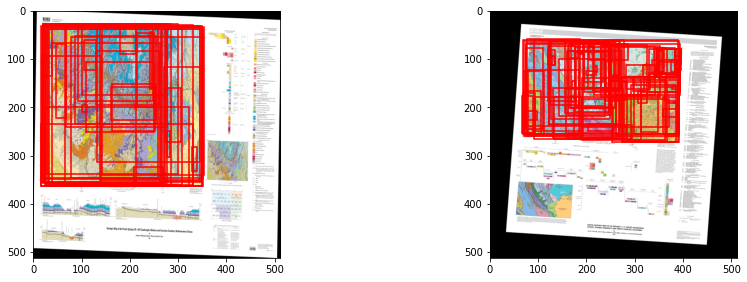

In [ ]:
# View some images and their bbox's in the training set.

images,labels=next(iter(Polydata_loader))

def view(images,labels,n=2,std=1,mean=0):
    figure = plt.figure(figsize=(15,10))
    images=list(images)
    labels=list(labels)
    for i in range(n):
        out=torchvision.utils.make_grid(images[i])
        inp=out.cpu().numpy().transpose((1,2,0))
        inp=np.array(std)*inp+np.array(mean)
        inp=np.clip(inp,0,1)  
        ax = figure.add_subplot(2,2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1,2,0)))
        l=labels[i]['boxes'].cpu().numpy()
        l[:,2]=l[:,2]-l[:,0]
        l[:,3]=l[:,3]-l[:,1]
        for j in range(len(l)):
            ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],linewidth=1.5,edgecolor='r',facecolor='none')) 

view(images=images,labels=labels,n=2,std=1,mean=0)

##Defining the model

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


num_classes = 2
# load an instance segmentation model pre-trained pre-trained on COCO
#model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                    hidden_layer,
                                                    num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model=model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
#@title
# import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# num_classes = 2  # 1 class (cell) + background = 2 classes
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) # use the torch model, pre-trained on coco dataset if set to True
# in_features = model.roi_heads.box_predictor.cls_score.in_features

# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# # now get the number of input features for the mask classifier
# in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# hidden_layer = 256
# # and replace the mask predictor with a new one
# model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                     hidden_layer,
#                                                     num_classes)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model=model.to(device)

# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.001)

In [ ]:
#@title
# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator

# # load a pre-trained model for classification and return
# # only the features
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# # FasterRCNN needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # OrderedDict[Tensor], and in featmap_names you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
#                                                 output_size=7,
#                                                 sampling_ratio=2)



# # put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=2,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)


##Training 

In [ ]:
# Split the data into train and test. Define data loader for training set

from sklearn.model_selection import train_test_split
# Polydataset = ResizedPolyDataset(%pwd, get_transform(train=True))
dataset_train = ResizedPolyDataset(os.path.join(drive_root,'training_resized256'), transforms=torchvision.transforms.ToTensor())#get_transform(train=True))
dataset_test = ResizedPolyDataset(os.path.join(drive_root,'training_resized256'), transforms=torchvision.transforms.ToTensor())#get_transform(train=False))

# split the dataset in train and test set
train_idx, test_idx = train_test_split(list(range(len(dataset_train))), test_size=.2)
dataset_train = torch.utils.data.Subset(dataset_train, train_idx)
dataset_test = torch.utils.data.Subset(dataset_test, test_idx)

In [ ]:
len(dataset_train), len(dataset_test)

(76, 20)

In [ ]:
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=True, num_workers=2,collate_fn=lambda x:list(zip(*x)))#collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=2, shuffle=True, num_workers=2,collate_fn=lambda x:list(zip(*x)))#collate_fn=utils.collate_fn)
len(data_loader_train), len(data_loader_test) # = len(dataset)/batch_size

(38, 10)

In [ ]:
# Perform training loop for n epochs
#Remove the following line if already have a pretrained model
model_rootdir = drive_root
#latest_model=2
loss_list = []
n_epochs = 10
model.train()
for epoch in tqdm(range(n_epochs)):
    loss_epoch = []
    iteration=1
    for images,targets in tqdm(data_loader_train):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        model=model.double()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()       
        optimizer.step()
        # print('loss:', losses.item())
        # loss_epoch.append(losses.item())
        loss_epoch.append(losses.item())
        # Plot loss every 10th iteration
        # if(iteration%10==0):
        plt.plot(list(range(iteration)), loss_epoch)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()
        iteration+=1
        # if(epoch%2==0):
        model_fe = latest_model() + 1
        save_path = os.path.join(model_rootdir,'MaskRCNNResults', 'model_resizedpoly_{}.pth'.format(model_fe))
        torch.save(model.state_dict(), save_path)
    loss_epoch_mean = np.mean(loss_epoch) 
    loss_list.append(loss_epoch_mean) 
    # loss_list.append(loss_epoch_mean)    
    print("Average loss for epoch = {:.4f} ".format(loss_epoch_mean))


###Not Used for NOW

In [ ]:
loss_list2 = [1.7433, 1.0864, 0.8294, 0.6757, 0.5676]

In [ ]:
# Plot training loss
plt.plot(list(range(n_epochs)), loss_list, label='traning loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# # Load previously trained model

# # model.load_state_dict(torch.load(save_path))
# # Load previously trained model 
# model_rootdir = '/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge'
# save_path = os.path.join(model_rootdir,'MaskRCNNResults')+'/model_1'+'.pth'
# model.load_state_dict(torch.load(save_path))
# # model=model.to(device)

<All keys matched successfully>

In [ ]:
# root_test = os.path.join(model_rootdir,'validation_tif_no_mosaic')
# dataset_test = MapPolyONLYFeatureDataset(root_test, transforms=torchvision.transforms.ToTensor()) # get_transform(train=True)
# data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=2, shuffle=False,collate_fn=lambda x:list(zip(*x)))

In [ ]:
# images, targets=next(iter(data_loader_test))
# images = list(image.to(device) for image in images)
# targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
# images

In [ ]:
# Look at some of the images and predicted bbox's after training

images, targets=next(iter(data_loader_test))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model=model.double()
model.eval()
output = model(images)

with torch.no_grad():
    view(images, output, 2)

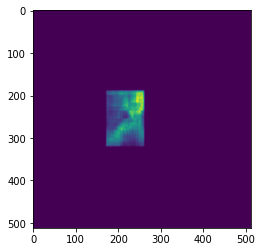

In [ ]:
plt.imshow(output[0]['masks'][20].cpu().detach().numpy()[0])

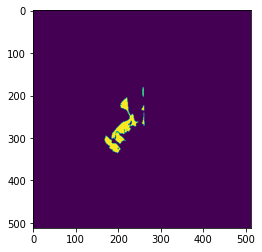

In [ ]:
plt.imshow(targets[0]['masks'][20])

In [ ]:
print(len(output[0]['boxes']))
print(len(output[0]['scores']))

100
100


In [ ]:
output[0]['boxes'][0]

tensor([  1.2246,   2.3434, 249.4204, 232.9688], device='cuda:0',
       dtype=torch.float64, grad_fn=<SelectBackward0>)

In [ ]:
# torchvision.utils.make_grid(images[i])
for i in range(2):
  # out = output[i]['scores'].to('cpu')
  # out = out.detach().numpy()
  for j in range(len(output[i]['scores'])):
    if j < 0.7:
      output[i]['boxes'][j] = torch.Tensor([0,0,0,0])

In [ ]:
def view_mask(targets, output, n=2, cmap='Greys'):
    figure = plt.figure(figsize=(15,10))
    for i in range(n):
      # plot target (true) masks
      prob=.07
      target_im = targets[i]['masks'][0].cpu().detach().numpy()
      for k in range(len(targets[i]['masks'])):
        target_im2 = targets[i]['masks'][k].cpu().detach().numpy()
        target_im2[target_im2>prob] = 1
        target_im2[target_im2<prob] = 0
        target_im = target_im+target_im2

      target_im[target_im>prob] = 1
      target_im[target_im<prob] = 0
      ax = figure.add_subplot(2,2, i+1)
      ax.imshow(target_im, cmap=cmap)
      # Plot output (predicted) masks
      output_im = output[i]['masks'][0][0, :, :].cpu().detach().numpy()
      for k in range(len(output[i]['masks'])):
        output_im2 = output[i]['masks'][k][0, :, :].cpu().detach().numpy()
        output_im2[output_im2>prob] = 1
        output_im2[output_im2<prob] = 0
        output_im = output_im+output_im2

      output_im[output_im>prob] = 1
      output_im[output_im<prob] = 0
      ax = figure.add_subplot(2,2, i+3)
      ax.imshow(output_im, cmap=cmap)

view_mask(targets, output, n=2)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##IOU Score

In [ ]:
def IoU(y_real, y_pred):
  # Intersection over Union loss function
  intersection = y_real*y_pred
  #not_real = 1 - y_real
  #union = y_real + (not_real*y_pred)
  union = (y_real+y_pred)-(y_real*y_pred)
  return np.sum(intersection)/np.sum(union)

def dice_coef(y_real, y_pred, smooth=1):
  intersection = y_real*y_pred
  union = (y_real+y_pred)-(y_real*y_pred)
  return np.mean((2*intersection+smooth)/(union+smooth))

def confusion_matrix(y_true, y_pred):
  y_true= y_true.flatten()
  y_pred = y_pred.flatten()*2
  cm = y_true+y_pred
  cm = np.bincount(cm, minlength=4)
  tn, fp, fn, tp = cm
  return tp, fp, tn, fn

def get_f1_score(y_true, y_pred):
    """Return f1 score covering edge cases"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred)
    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score     

In [ ]:
# Get IoU score for whole test set
IoU_scores_list = []
dice_coef_scores_list = []
f1_scores_list = []
skipped = 0
for images,targets in tqdm(data_loader_test):
  images = list(image.to(device) for image in images)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

  model=model.double()
  model.eval()
  output = model(images)
  # print(targets)
  target_im = targets[0]['masks'][0].cpu().detach().numpy()
  for k in range(len(targets[0]['masks'])):
    target_im2 = targets[0]['masks'][k].cpu().detach().numpy()
    target_im2[target_im2>0.5] = 1
    target_im2[target_im2<0.5] = 0
    target_im = target_im+target_im2

  target_im[target_im>0.5] = 1
  target_im[target_im<0.5] = 0
  target_im = target_im.astype('int64')
  
  # Plot output (predicted) masks
  output_im = output[0]['masks'][0][0, :, :].cpu().detach().numpy()
  for k in range(len(output[0]['masks'])):
    output_im2 = output[0]['masks'][k][0, :, :].cpu().detach().numpy()
    output_im2[output_im2>0.5] = 1
    output_im2[output_im2<0.5] = 0
    output_im = output_im+output_im2

  output_im[output_im>0.5] = 1
  output_im[output_im<0.5] = 0
  output_im = output_im.astype('int64')

  if target_im.shape != output_im.shape:
    skipped+=1
    continue
  
  dice_coef_score = dice_coef(y_real=target_im, y_pred=output_im)
  dice_coef_scores_list.append(dice_coef_score)
  IoU_score = IoU(y_real=target_im, y_pred=output_im) 
  IoU_scores_list.append(IoU_score)
  f1_score = get_f1_score(target_im, output_im)
  f1_scores_list.append(f1_score)

print('mean IoU score for test set:', np.mean(IoU_scores_list))
print('mean Dice Coefficient score for test set:', np.mean(dice_coef_scores_list))
print('mean f1 score for test set:', np.mean(f1_scores_list))


  0%|          | 0/10 [00:00<?, ?it/s]

mean IoU score for test set: 0.0559421331780271
mean Dice Coefficient score for test set: 0.8515995025634766
mean f1 score for test set: 0.0022295223924545505


In [ ]:
print('mean IoU score for test set:', np.mean(IoU_scores_list))

In [ ]:
for i in range(2):
  # plot target (true) masks
  target_im = targets[i]['masks'][0].cpu().detach().numpy()
  for k in range(len(targets[i]['masks'])):
    target_im2 = targets[i]['masks'][k].cpu().detach().numpy()
    target_im2[target_im2>0.5] = 1
    target_im2[target_im2<0.5] = 0
    target_im = target_im+target_im2

  target_im[target_im>0.5] = 1
  target_im[target_im<0.5] = 0
  # Plot output (predicted) masks
  output_im = output[i]['masks'][0][0, :, :].cpu().detach().numpy()
  for k in range(len(output[i]['masks'])):
    output_im2 = output[i]['masks'][k][0, :, :].cpu().detach().numpy()
    output_im2[output_im2>0.5] = 1
    output_im2[output_im2<0.5] = 0
    output_im = output_im+output_im2

  output_im[output_im>0.5] = 1
  output_im[output_im<0.5] = 0

IoU(y_real=target_im, y_pred=output_im) 


0.5406863299054507

27


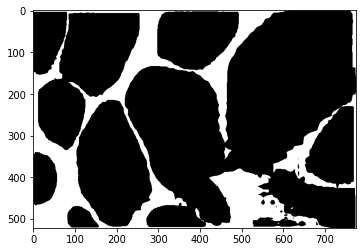

In [ ]:
len(output[0]['masks'])
im = output[0]['masks'][0][0, :, :].cpu().detach().numpy()
# im2 = outputs[0]['masks'][1][0, :, :].cpu().detach().numpy()
it = 0
for i in range(len(output[0]['masks'])):
  im2 = output[0]['masks'][i][0, :, :].cpu().detach().numpy()
  im2[im2>0.5] = 1
  im2[im2<0.5] = 0
  im = im+im2
  it+=1
print(it)
# im_new = np.concatenate((im, im2)) 
im[im>0.5] = 1
im[im<0.5] = 0
plt.imshow(im, cmap='Greys')
# outputs[0]['masks']

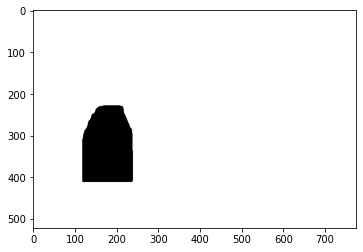

In [ ]:
# im = outputs[0]['masks'][20][0, :, :].cpu().detach().numpy()
# im[im>0.5] = 1
# im[im<0.5] = 0
# plt.imshow(im, cmap='Greys')

In [ ]:
# # outputs = model(images)
# outputs = [{k: v.to(device) for k, v in t.items()} for t in output]
# pred_score = list(outputs[0]['scores'].detach().numpy())
# pred_t = [pred_score.index(x) for x in pred_score if x>=threshold][-1]
# masks = (outputs[0]['masks']>0.5).squeeze().numpy()
# masks = masks[:pred_t+1]

##Inference

In [ ]:
# sp = '/content/drive/MyDrive/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/trained_models'
# model_names = os.listdir(os.path.join(sp))
# model_names
def latest_model():
  model_rootdir = '/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge'
  sp = os.path.join(model_rootdir,'MaskRCNNResults')
  largest = 0
  model_names = [model_name for model_name in os.listdir(sp) if model_name.startswith('model_resizedpoly')]
  for i in model_names:
    nr = int(list(filter(str.isdigit, i))[0])
    if nr>largest:
      largest = nr
  return largest

latest_model()

9

In [ ]:
# Load previously trained model

# model.load_state_dict(torch.load(save_path))
# Load previously trained model 
model_rootdir = '/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge'
save_path = os.path.join(model_rootdir,'MaskRCNNResults','model_resizedpoly_{}.pth'.format(latest_model()))
model.load_state_dict(torch.load(save_path,map_location=torch.device('cpu')))
# model=model.to(device)

<All keys matched successfully>

(11282, 10482, 3)

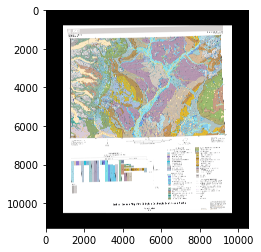

In [ ]:
import random

#read a random image from validation set
val_root = os.path.join(drive_root,'validation_tif_no_mosaic')
val_list = os.listdir(val_root)
idx = random.randint(0, len(val_list)-1)
large_image = cv2.imread(os.path.join(val_root,val_list[idx]))
plt.imshow(large_image)
large_image.shape

In [ ]:
#check/print out the file path
os.path.join(val_root,val_list[idx])

'/content/gdrive//My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge/validation_tif_no_mosaic/AK_Dillingham.tif'

In [ ]:
large_image = Image.fromarray(large_image)  

In [ ]:
resized_image = large_image.resize((512,512))

In [ ]:
resized_image = np.array(resized_image)  


0 0 512 512


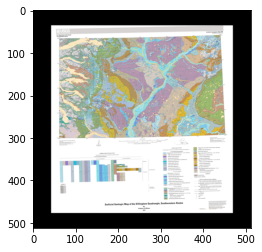

In [ ]:
#The following piece of code will extract the coordinates of the actual map piece from the figure

import cv2
import numpy as np

## (1) Convert to gray, and threshold
gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

## (2) Morph-op to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

## (3) Find the max-area contour
cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
cnt = sorted(cnts, key=cv2.contourArea)[-1]

## (4) Crop and save it
x,y,w,h = cv2.boundingRect(cnt)
dst = resized_image[y:y+h, x:x+w]
print(x,y,w,h)
plt.imshow(dst)


In [ ]:
resized_image.shape

(512, 512, 3)

In [ ]:
resized_image_4inference=torch.from_numpy(resized_image.reshape(1,512,512,3)/256).permute(0,3,1,2)
resized_image_4inference.shape

torch.Size([1, 3, 512, 512])

In [ ]:
model=model.double()
model.eval()
pred = model(resized_image_4inference.cuda())

In [ ]:
im2 = resized_image.copy()
for i in range(len(pred[0]['masks'])):
    msk=pred[0]['masks'][i,0].detach().cpu().numpy()
    scr=pred[0]['scores'][i].detach().cpu().numpy()
    scr_thr = 0.6
    prob_thr=0.3
    if scr>scr_thr :
        im2[:,:,0][msk>prob_thr] = random.randint(0,255)
        im2[:, :, 1][msk > prob_thr] = random.randint(0,255)
        im2[:, :, 2][msk > prob_thr] = random.randint(0, 255)


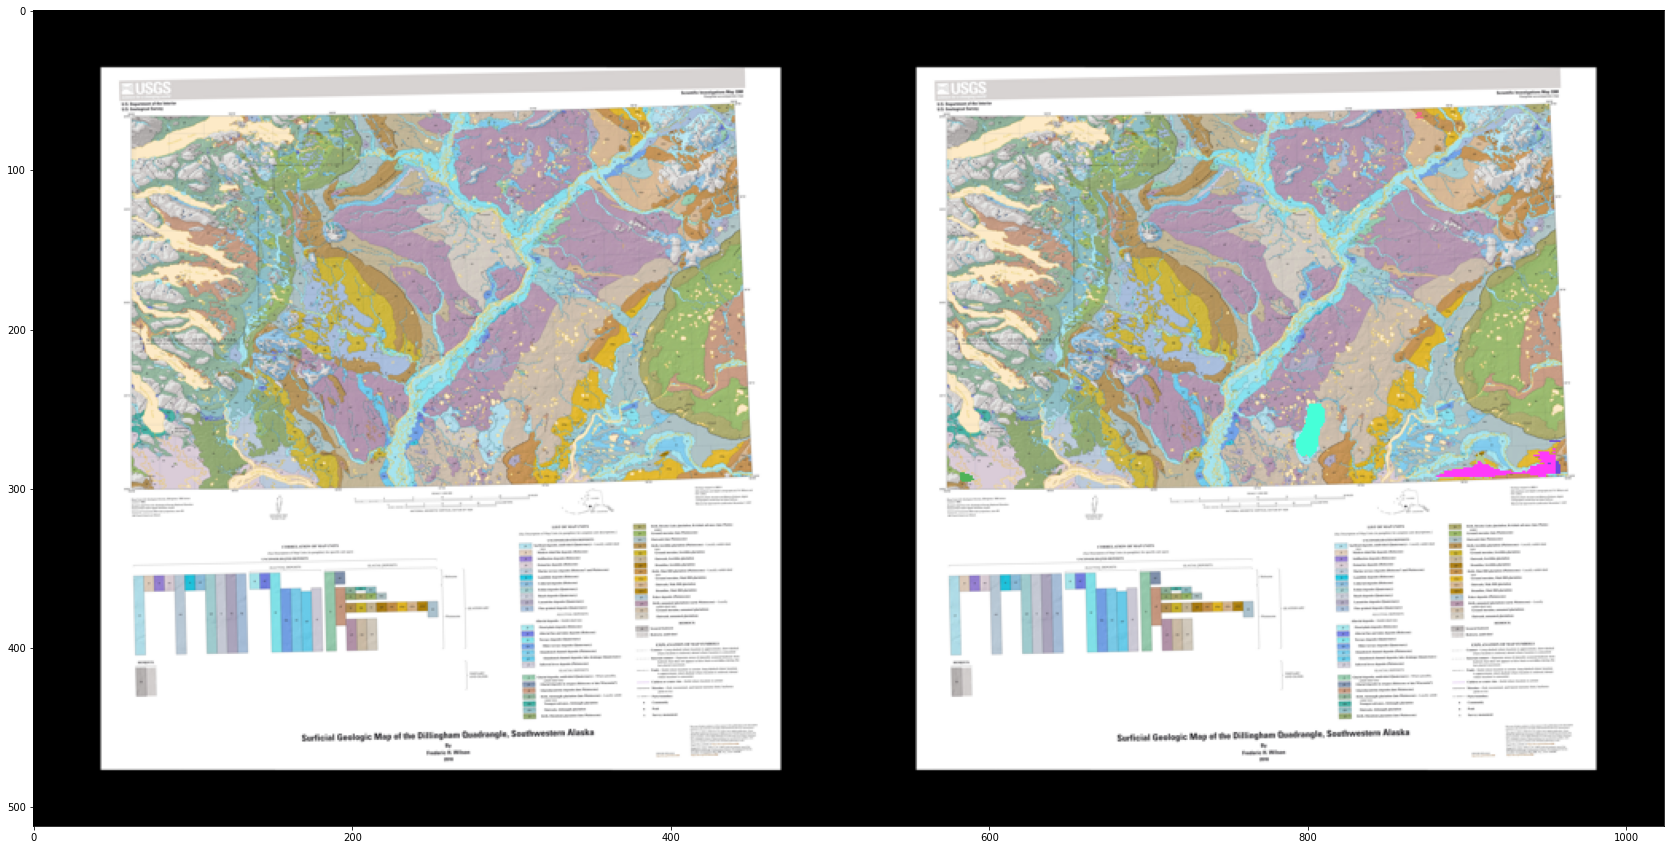

In [ ]:
plt.figure(figsize = (80,15))
plt.imshow(np.hstack([resized_image,im2]))

##2nd Inference

In [ ]:
# Load previously trained model

# model.load_state_dict(torch.load(save_path))
# Load previously trained model 
model_rootdir = '/content/gdrive/My Drive/Colab Notebooks/DARPA_Map_Feature_Extraction_Challenge'
save_path = os.path.join(model_rootdir,'MaskRCNNResults','epoch-6.pth')
model.load_state_dict(torch.load(save_path,map_location=torch.device('cpu')))
# model=model.to(device)